# Homework: FX Carry Strategy
Robert Hatem

## Carry Strategy
The carry strategy is borrowing at low interest rates and lending at high interest rates. This is often done by borrowing in a low-yield currency like USD, ocnverting to foreign currency, and lending at higher interest rates in the forein currency. Here we will execute the trade using cross-currency swaps.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
from fred import Fred
%matplotlib inline

In [4]:
# API key
quandl.ApiConfig.api_key = "wFcUAbwJv3FbxzDwExsY"

In [5]:
# for quandl data
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities, start_date='', end_date=''):
    print("Fetching from Quandl")
#    qdata = quandl.get(list(my_securities), start_date="2018-02-05", end_date="2018-03-01", returns="pandas")
    qdata = quandl.get(my_securities, start_date=start_date, end_date=end_date, collapse='weekly')
    return qdata

### Upload data from Quandl
* Yield curve: https://www.quandl.com/data/YC-Global-Yield-Curves/documentation
* Currency exchange rates: https://www.quandl.com/data/CUR-Foreign-Exchange-Rates/documentation
* Libor: https://fred.stlouisfed.org/series/USD3MTD156N
  * https://research.stlouisfed.org/docs/api/fred/series_observations.html#output_type

In [6]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
                #coupon_half_yr = 0.5*spot_rate
                coupon_quarter = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_quarter*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_quarter))/tenor
    return zcb_rates

In [413]:
def upload_data(start_date='2014-07-01'):
    cols = {'PAK':['3_Month','6_Month','1_Year','3_Year','5_Year'],
            'ROU':['6_Month','1_Year','3_Year','5_Year'],
            'IDN':['1_Year','2_Year','3_Year','4_Year','5_Year'], 
            'USA':['1_Month','3_Month','6_Month','1_Year','2_Year','3_Year','5_Year']}
    currencies = {'PAK':'CUR/PKR', 'ROU':'CUR/RON', 'IDN':'CUR/IDR'}  # foreign exchange rates
    
    data = dict()  # upload data
    
    libor = {'FRED/LIOR3M':'Libor_3M'}
    # Libor rates
    #df = fetch_quandl(l, start_date=start_date)  # from quandl
    #df = pd.read_csv('FRED_3M_Libor.csv').rename(columns={'DATE':'Date', 'USD3MTD156N':'Libor_3M'}).set_index('Date')  # via csv
    #df.index = pd.to_datetime(df.index)
    #df1 = df.resample('D').ffill().rename(columns={"Value": "Libor_3M"})
    #df1.Libor_3M = df1.Libor_3M.replace({'.':np.nan}).astype(np.float64).fillna(method='ffill')/100

    fr = Fred(api_key='50390f24fc44c3c608b53c9f35cbc53c',response_type='df')
    params = {'output_type':1,'observation_start':'2014-09-02','frequency':'wesu'}
    df = fr.series.observations('USD3MTD156N',params=params).drop(columns=['realtime_end', 'realtime_start']).rename(columns={'value':'Libor_3M','date':'Date'}) .set_index('Date').fillna(method='ffill')/100

    data[libor['FRED/LIOR3M']] = df
    
    i=0
    for country, col in cols.items():
        df = fetch_quandl('YC/'+country, start_date=start_date).rename(columns={'12-Month':'1-Year'})/100  # spot rates
        df.columns = [name.replace('-','_') for name in df.columns.tolist()]   # remove dashes "-"
        df1 = df.loc[:, cols[country]]
        df1['5_Year_spot'] = df1['5_Year'].copy()
        
        if country != 'USA':
            df4 = fetch_quandl(currencies[country], start_date=start_date).rename(columns={'RATE':'FX_rate'})  # get foregin exchange rates
            df1 = df1.merge(df4, how='left', left_index=True, right_index=True)
        elif country == 'USA':
            df1 = df1.assign(FX_rate = 1.0)
        
        #df1 = df1.resample('W-WED').last()
        
        df2 = df1.loc[:,cols[country]].T    # spot rates to zero rates
        cols2 = df2.index.tolist()
        df2.index = [int(name.replace('_Year','').replace('_Month','')) for name in cols[country]]
        df3 = compute_zcb_curve(df2).T
        df3.columns = cols2
        
        for c in cols[country]: df1[c] = df3[c].values  # replace spot with zero
        
        df1.columns = [name + '_' + country for name in df1.columns.tolist()]  # add suffixes to col names
        data3 = df1 if i==0 else data3.merge(df1, left_index=True, right_index=True)  # attach new country
        i+=1
        
        df1 = df1.merge(data[libor['FRED/LIOR3M']], left_index=True, right_index=True)
        
        data[country] = df1
    
    data3 = data3.merge(data[libor['FRED/LIOR3M']], how='left', left_index=True, right_index=True)   # add Libor
    
    return data3


In [414]:
data = upload_data()

In [415]:
def spot_rate(zcb, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        sr = None
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        coupons_pv_x = 0.5*np.exp(-r*times).sum()
        final_pv = np.exp(-tenor*r[-1])
        sr = (1.0 - final_pv) / coupons_pv_x # Solves x + c * delta = 1.0
    return sr

def compute_spot_rates(zcb_rates):
    spot = zcb_rates.copy()
    for curve in zcb_rates.columns:
        zcb = zcb_rates[curve]
        for tenor, rate in zcb.iteritems():
            if tenor>0.001:
                spot[curve][tenor] = spot_rate(zcb, tenor)
    return spot

def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p

In [571]:
def carry_strategy(data, country1='PAK',country2='USA'):
    cols = {'PAK':['3_Month_PAK','6_Month_PAK','1_Year_PAK','3_Year_PAK','5_Year_PAK','5_Year_spot_PAK','FX_rate_PAK'],
            'ROU':['6_Month_ROU','1_Year_ROU','3_Year_ROU','5_Year_ROU', '5_Year_spot_ROU', 'FX_rate_ROU'],
            'IDN':['1_Year_IDN','2_Year_IDN','3_Year_IDN','4_Year_IDN','5_Year_IDN','5_Year_spot_IDN', 'FX_rate_IDN'], 
            'USA':['1_Month_USA','3_Month_USA','6_Month_USA','1_Year_USA','2_Year_USA','3_Year_USA','5_Year_USA','5_Year_spot_USA','FX_rate_USA']}
    
    cols_two_countries = cols[country1]+cols[country2]+['Libor_3M']
    df = data.loc[:, cols_two_countries]
    swap_rates_within_50bps = (df['5_Year_spot_'+country1] - df['5_Year_spot_'+country2]) <= 0.0050
    df = df.assign(sr_within_50bps = swap_rates_within_50bps.astype(float))
    
    df['bp_today_'+country1] = 0.0
    df['bp_prev_'+country1] = 0.0
    df['bp_today_'+country2] = 0.0
    df['bp_prev_'+country2] = 0.0
       
    df = df.assign(FX_lend_fact=np.nan)
    df = df.assign(bp_lend_fact=np.nan)
    df = df.assign(FX_borr_fact=np.nan)
    
    df = df.assign(notional_close = 0.0)  # closing out our lending position
    df = df.assign(notional_open = -1e7)  # us lending
    df = df.assign(borrow_interest = 0.0)
    
    
    cols_tenor = {'PAK':['3_Month_PAK','6_Month_PAK','1_Year_PAK','3_Year_PAK','5_Year_PAK'],
                  'ROU':['6_Month_ROU','1_Year_ROU','3_Year_ROU','5_Year_ROU'],
                  'IDN':['1_Year_IDN','2_Year_IDN','3_Year_IDN','4_Year_IDN','5_Year_IDN'], 
                  'USA':['1_Month_USA','3_Month_USA','6_Month_USA','1_Year_USA','2_Year_USA','3_Year_USA','5_Year_USA']}
    
    tenor_indices = {'PAK':[3/12, 6/12, 1, 3, 5],
                     'ROU':[6/12, 1, 3, 5],
                     'IDN':[1, 2, 3, 4, 5], 
                     'USA':[1/12,3/12,6/12,1,2,3,5]}
    
    for i in range(df.shape[0]):
        for country in [country1, country2]:
            rates = df.iloc[i].loc[cols_tenor[country]].copy()
            rates.index = tenor_indices[country]
            
            bond_price_today = bond_price(zcb=rates, coupon_rate= df.iloc[i].at['5_Year_spot_'+country], tenor=5)
            df.iat[i, np.where( df.columns.values=='bp_today_'+country)[0][0]] = bond_price_today
            
            if i!=0:
                bond_price_prev = bond_price(zcb=rates, coupon_rate=df.iloc[i-1].at['5_Year_spot_'+country], tenor=5-1/52)
                df.iloc[i].at['bp_prev_'+country] = bond_price_prev
                df.iat[i, np.where(df.columns.values=='bp_prev_'+country)[0][0]] = bond_price_prev
               
        if i>0:
            N_t = 1e7
            f_lend_t = df.iat[i-1, np.where(df.columns.values=='FX_rate_'+country1)[0][0]]
            f_lend_t1 = df.iat[i, np.where(df.columns.values=='FX_rate_'+country1)[0][0]]
            V_lend_t = df.iat[i-1, np.where(df.columns.values=='bp_today_'+country1)[0][0]]
            V_lend_t1 = df.iat[i, np.where(df.columns.values=='bp_prev_'+country1)[0][0]]

            FX_lend_fact = f_lend_t/f_lend_t1
            bp_lend_fact = V_lend_t1/V_lend_t

            N_t1 = (1-df.iat[i-1, np.where(df.columns.values=='sr_within_50bps')[0][0]])*N_t*FX_lend_fact*bp_lend_fact
            
            df.iat[i, np.where(df.columns.values=='FX_lend_fact')[0][0]] = FX_lend_fact
            df.iat[i, np.where(df.columns.values=='bp_lend_fact')[0][0]] = bp_lend_fact
            df.iat[i, np.where(df.columns.values=='notional_close')[0][0]] = N_t1
            
            df.iat[i, np.where(df.columns.values=='notional_open')[0][0]] = (1-df.iat[i-1, np.where(df.columns.values=='sr_within_50bps')[0][0]]) * df.iat[i, np.where(df.columns.values=='notional_open')[0][0]]
            
            P = 8e6
            f_borr_t = df.iat[i-i, np.where(df.columns.values=='FX_rate_'+country2)[0][0]]
            f_borr_t1 = df.iat[i, np.where(df.columns.values=='FX_rate_'+country2)[0][0]]
            r = (1/52)*(df.iat[i-1, np.where(df.columns.values=='Libor_3M')[0][0]] + 0.0050)
            
            FX_borr_fact = 1# f_borr_t/f_borr_t1
            
            df.iat[i, np.where(df.columns.values=='FX_borr_fact')[0][0]] = FX_borr_fact
            df.iat[i, np.where(df.columns.values=='borrow_interest')[0][0]] = -P*FX_borr_fact*r * (1-df.iat[i-1, np.where(df.columns.values=='sr_within_50bps')[0][0]])
            
    #df.notional_open = df.notional_open * (1-df.sr_within_50bps)
    cashflow = df.notional_close + df.notional_open + df.borrow_interest
    df = df.assign(cashflow=cashflow)
    df = df.assign(pnl = 1e7+cashflow.cumsum())
    df.iat[0, np.where(df.columns.values=='cashflow')[0][0]] = np.nan
    
    ret = df.pnl.pct_change(fill_method='pad')
    #ret[0] = 0
    #ret[1] = 0
    df = df.assign(ret = ret)
    
    return df

In [572]:
# execute strategy
country1 = 'PAK'
country2 = 'USA'
d = carry_strategy(data, country1=country1, country2=country2)

In [573]:
cols=[#'3_Month_PAK', '6_Month_PAK', '1_Year_PAK', '3_Year_PAK', '5_Year_PAK',
      #'5_Year_spot_'+country1, 
      #'FX_rate_PAK', 
      #'1_Month_USA', '3_Month_USA','6_Month_USA', '1_Year_USA', '2_Year_USA', '3_Year_USA', '5_Year_USA',
      #'5_Year_spot_'+country2,
      #'FX_rate_ROU', 
      'Libor_3M', 
      'sr_within_50bps',
      #'bp_today_PAK', 'bp_prev_PAK', #'bp_today_USA', 'bp_prev_USA', 
      'FX_lend_fact', 'bp_lend_fact', 'FX_borr_fact',
      'notional_close', 'notional_open', #'cf_borrow_sold','cf_borrow_close',
      'borrow_interest',
      'cashflow', 'pnl','ret']

d.loc[:,cols].head(5)

,Libor_3M,sr_within_50bps,FX_lend_fact,bp_lend_fact,FX_borr_fact,notional_close,notional_open,borrow_interest,cashflow,pnl,ret
Date,,,,,,,,,,,
2014-12-07,0.002350,0.0,NaN,NaN,NaN,0.000000e+00,-10000000.0,0.000000,NaN,0.000000,NaN
2014-12-14,0.002400,0.0,1.008911,1.006142,1.0,1.015107e+07,-10000000.0,-1130.769231,149941.390302,149941.390302,inf
2015-01-04,0.002554,0.0,0.995685,1.036223,1.0,1.031751e+07,-10000000.0,-1138.400000,316371.149133,466312.539435,2.109965
2015-01-11,0.002526,0.0,1.003003,1.016495,1.0,1.019547e+07,-10000000.0,-1162.123077,194311.026362,660623.565797,0.416697
2015-01-18,0.002538,0.0,0.999554,1.009209,1.0,1.008758e+07,-10000000.0,-1157.846154,86427.011743,747050.577540,0.130826


In [574]:
# plot pnl
def plot_pnl(data, show_cashflow=True, show_factors=True, start=0, end=250):
    fig, ax1 = plt.subplots(figsize=(13,4))

    d = data.iloc[start:end].copy()
    color = 'k'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('PnL', color=color)
    ax1.plot(d.index, d.pnl, color=color, marker='.', linestyle='-', linewidth=1, markersize=3, label='PnL')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.xticks(rotation=30)

    if show_cashflow:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        pos_cashflow = d.cashflow*(d.cashflow>0).replace({False:np.nan})
        neg_cashflow = d.cashflow*(d.cashflow<0).replace({False:np.nan})

        color = 'r'
        ax2.set_ylabel('Cashflow', color=color)  # we already handled the x-label with ax1
        ax2.plot(d.index, d.cashflow, color=color, marker='', linestyle='-', linewidth=0.3, markersize=5, label='cashflow' )
        ax2.scatter(d.index, pos_cashflow, color='b', marker='.', linestyle='-', linewidth=1, label='positive cashflow' )
        ax2.scatter(d.index, neg_cashflow, color='m', marker='.', linestyle='-', linewidth=1, label='negative cashflow')
        ax2.axhline(y=1, linewidth=.5, color='grey', linestyle='--')
        ax2.tick_params(axis='y', labelcolor=color)

    fig.legend(framealpha=1)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('PnL and cashflow over time')
    plt.show()
    
    ######### --------- ###########
    if show_factors:
        fig, ax1 = plt.subplots(figsize=(12,4))

        color = 'k'
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Factors', color=color)
        ax1.plot(d.index, d.FX_lend_fact, color=color, marker='.', linestyle='-', linewidth=.8, markersize=5, label='FX factor')
        ax1.plot(d.index, d.bp_lend_fact, color='r', marker='.', linestyle='-', linewidth=.8, markersize=5, label='Bond price factor')
        ax1.plot(d.index, d.FX_lend_fact*d.bp_lend_fact, color='g', marker='.', linestyle='-', linewidth=.8, markersize=5, label='Overall factor')

        ax1.axhline(y=1, linewidth=1, color='grey', linestyle='--')

        ax1.tick_params(axis='y', labelcolor=color)
        #plt.ylim(0.97,1.05)
        plt.xticks(rotation=30)

        fig.legend()
        plt.title('Factors for lending payments')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

### PAK and USA
First we'll use the two countries with the largest spread in interest rates; USA and Pakistan. Pakistan has a median 5-year zero rate of 0.0805 while the US has a much smaller median rate of 0.0181. This reflects the higher credit risk for investing in projects in developing countries than in the US, in part. Let's plot a typical yield curve for Pakistan and the US.

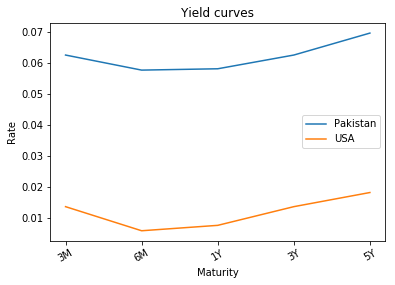

In [575]:
x_label = ['3M', '6M', '1Y', '3Y', '5Y']

plt.plot(x_label, data.iloc[100,0:5], label='Pakistan')
plt.ylabel('Rate')
plt.xlabel('Maturity')
plt.legend()
plt.xticks(rotation=30)
#plt.show()

plt.plot(x_label, data.iloc[100,[21,22,23,25,26]], label='USA')
plt.ylabel('Rate')
plt.xlabel('Maturity')
plt.legend()
plt.xticks(rotation=30)
plt.title('Yield curves')
plt.show()

The rates are highest for 3-month loans, the shortest maturity. This is unexpected, since the yield curve usually slopes up to the right, reflecting the belief that interest rates will rise in the future, corresponding to an economic expansion. In this case, investors avoid long-term bonds to avoid locking in rates that will rise in the future, which would lower the prices of the bonds. Instead, they purchase short-term bonds while they wait for interest rates to rise. As investors crowd in to short-term bonds, their yields drop, and it lowers the left part of the yield curve.  

The high 3-month yields could indicate that long-term investments are riskier than short term investments. The high 3-month yield could reflect an expectation that risk is high in the next 3 months, then lower after that. There could also be another reason.  


Next we run the carry strategy and plot it's PnL. Here is a summary of the carry strategy:
* Start in USD. In each week, borrow 8MM USD at 3M-Libor plus 50 bps. Add 2MM USD of your own cash. Thus the strategy is levered 5x.
* Convert the 10MM USD to foreign currency (PAK rupee) at the prevailing FX rate. Invest those rupees by buying 5y bonds.
* After one week, sell the bonds at their new price (the new bond price is calculated using the prevailing yield curve, the current spot rate, and a tenor of 5 years minus 1 week). Conver the rupees back to USD at the new FX rate. The conversion is written out below:

$$ N_t = N_{t-1}\frac{f_{t-1}}{V_{t-1}}\frac{V_t}{f_t} $$

where
* $N_t$ = notional received after exiting strategy after one week (in USD)
* $N_{t-1}$ = notional spent to enter strategy at beginning of week (10MM USD)
* $f_{t-1}$ = Exchange rate in PAK/USD at time of entering the position
* $f_{t}$ = Exchange rate at time of exiting the position
* $V_{t-1}$ = Price of bonds when buying (entering the strategy)
* $V_{t}$ = Price of bonds when selling (exiting the strategy)  

The value of the bonds changes in response to interest rates. The price of the bonds will increase more in one week than similar bonds would increase in one week in the US, because interest rates are higher in Pakistan.  

The stratgy has two sources of risk; it's exposed to FX rate changes and yield curve flattening. It's possible that the FX rates change unfavorably in the week of holding the security: this is $\frac{f_{t-1}}{f_t}$. If this "FX rate factor". The "bond price factor" is $\frac{V_{t}}{V_{t-1}}$. This factor will be less than one if the yield curve flattens. If both of these factors are greater than one in the week, then the contribution will be positive (still might lose money due to interest payment on the borrowing currency).  

At the end of the week, we also close our borrowing position by repaying the loan plus interest. The loan was used to buy bonds in the low-interest foreign currency (or just USD), but we assume that the bond prices do not change in this short time period. Thus this borrowing is sublject only to FX rate changes, not interest rate changes. The formula for the interest rate paying is:

$$I_t = P \frac{1}{V_t}\frac{V_{t+1}}{1} (\frac{1}{52}) L_{3M}+0.050 = P\frac{}{} \frac{1}{52} (L_{3M}+0.050)$$

* $P$ = principal (8MM USD)
* Note that $V_{t+1} = V_{t}$ by asusmption, so they cancel out.
* $L_{3M}$ is the 3-month Libor rate in USD. This is the rate we are borrowing at, and it should be lower than the interest rates in the high-interest currency if we hope to make money. Since we only consider USD Libor, that means for our strategy the low-interest-rate currency that we borrow at will always be USD.

Let's run the strategy for Pakistan and United States and see the PnL.

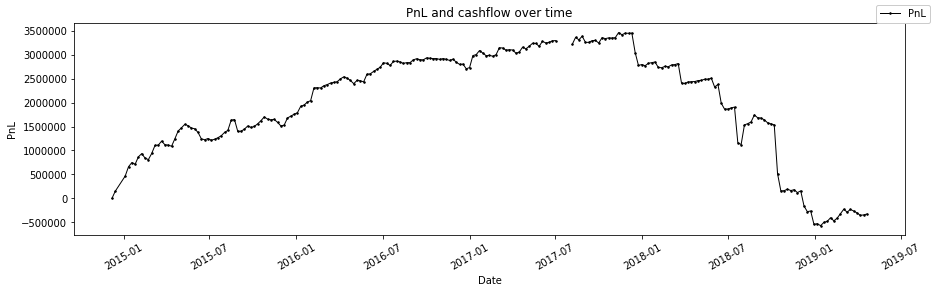

In [576]:
d = carry_strategy(data, country1='PAK', country2='USA')
plot_pnl(data=d,show_cashflow=False,show_factors=False,start=0,end=250)

The PnL in the top plot shows a steady rise from about 2015-2018, then a somewhat steaper decline to 2019. There a few sharp drops. Let's overlay the cashflows to visualize the drops in the PnL.

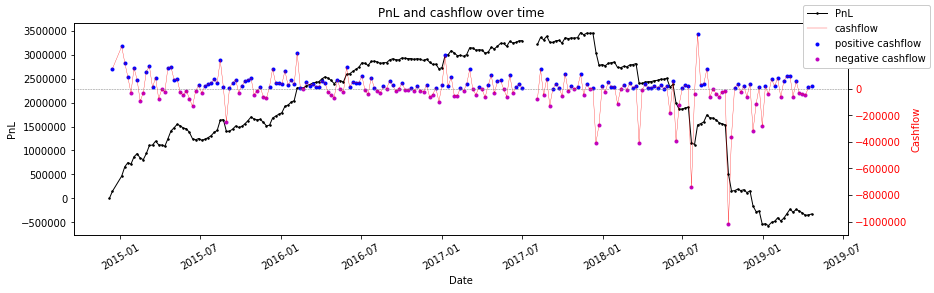

In [577]:
plot_pnl(data=d,show_cashflow=True,show_factors=False,start=0,end=250)

The red line shows the daily cashflows, with blue dots for days that made money and magenta dots for days that lost money. The first three years show small daily movements with a net positive direction. But after 2018, there a several days with large losses, leading to the steep drops in PnL. Let's zoon in around summer 2018 to understand the large drops.

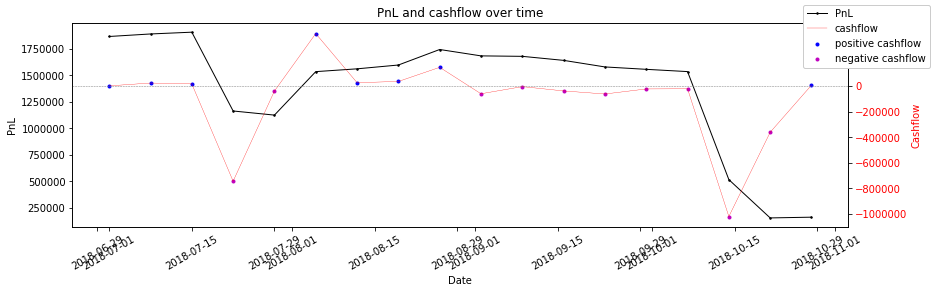

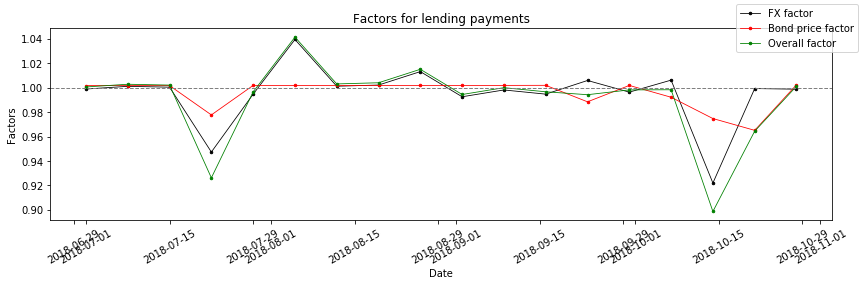

In [578]:
plot_pnl(data=d,show_cashflow=True,show_factors=True,start=182,end=200)

Two largest drops are shown above (magenta). As stated, the losses an be due to unfavorable changes in FX rates and due to change in interest rates (reflected in bond prices). The table for these days is shown. In the second plot, we plot the daily factors for FX rates and bond prices $(\frac{f_{t-1}}{f_t}$ and $\frac{V_t}{V_{t-1}})$ to understand what is driving the drop in prices. The red and black lines both show values less than one on the two high-loss weeks. Both FX rates and interest rates contributed to the large losses. The overall factor (product of the two indiviudal factors) is shown in green. The FX factor (black) is usually farther from one than the bond price factor (red). This suggests that losses and gains are driven by FX rate changes more than interest rate changes on any given week.

In [579]:
d.iloc[182:200,22:]

,FX_lend_fact,bp_lend_fact,FX_borr_fact,notional_close,notional_open,borrow_interest,cashflow,pnl,ret
Date,,,,,,,,,
2018-07-01,0.998892,1.001701,1.0,1.000591e+07,-10000000.0,-4357.153846,1.551960e+03,1.865448e+06,0.000833
2018-07-08,1.001109,1.001701,1.0,1.002812e+07,-10000000.0,-4363.123077,2.375892e+04,1.889207e+06,0.012736
2018-07-15,1.000411,1.001701,1.0,1.002113e+07,-10000000.0,-4365.276923,1.676467e+04,1.905972e+06,0.008874
2018-07-22,0.947275,0.977684,1.0,9.261359e+06,-10000000.0,-4363.923077,-7.430047e+05,1.162967e+06,-0.389830
2018-07-29,0.994693,1.001869,1.0,9.965524e+06,-10000000.0,-4372.523077,-3.884900e+04,1.124118e+06,-0.033405
2018-08-05,1.039484,1.001869,1.0,1.041427e+07,-10000000.0,-4365.646154,4.099057e+05,1.534024e+06,0.364646
2018-08-12,1.001210,1.001869,1.0,1.003081e+07,-10000000.0,-4376.446154,2.643829e+04,1.560462e+06,0.017235
2018-08-19,1.002156,1.001869,1.0,1.004029e+07,-10000000.0,-4363.830769,3.592739e+04,1.596389e+06,0.023024
2018-08-26,1.013170,1.001869,1.0,1.015064e+07,-10000000.0,-4330.707692,1.463082e+05,1.742698e+06,0.091649


The rows at 7-22 and 10-14 show large losses, matching the graph.  
The final PnL of the strategy a loss, as expected from the PnL chart:

In [598]:
print('Final returns:', round(d.pnl[-1]/2e7, 3))

Final returns: -0.016


Now we plot the distribution of weekly returns.

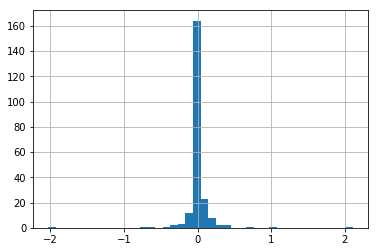

In [600]:
d.ret[2:].hist(bins=40);

There are a large number of slightly negative returns, while a typical carry strategy has a many slightly *positive* trades. A typical carry also has a cluster of large negative weeks, but our strategy does now show a large cluster, only a small number of large negative days. The left tail does not appear fatter than the right. To test further, let's test the skew of returns:

In [610]:
print('Skew of returns:', round(d.ret[2:].skew(),4))

Skew of returns: 0.5804


The skew is positive, while a typical carry strategy would have negative skew. This result is now surprising from our graph, but surprised compared to a typical carry strategy. Now let's check another high-yield currency; Indonesian Rupiah. The Rupiah does not have yields as large as the Pakistani Rupee, but still higher than the USD.

### Indonesian Rupiah vs. US dollar

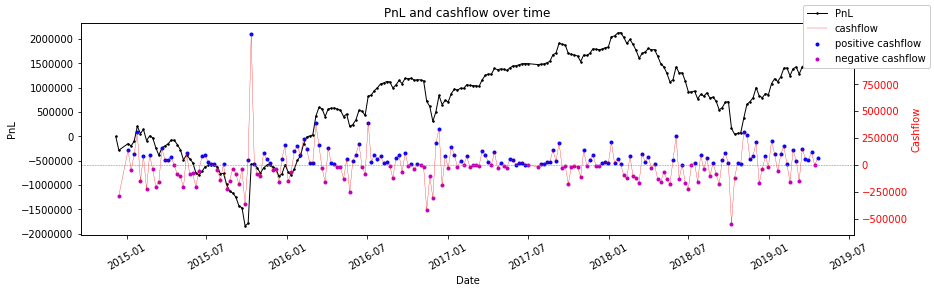

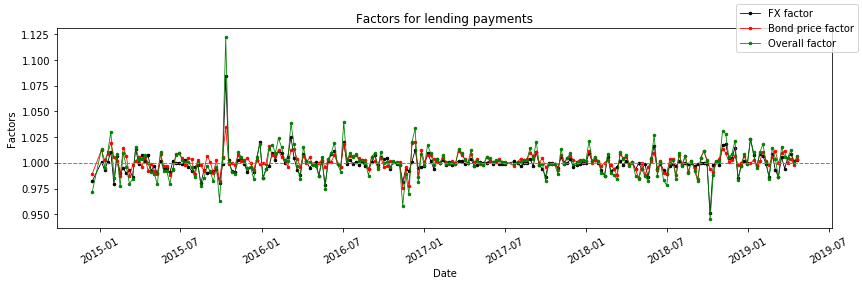

In [630]:
d1 = carry_strategy(data, country1='IDN', country2='USA')
plot_pnl(data=d1,show_cashflow=True,show_factors=True,start=0,end=250)

In [604]:
print('Final returns:', round(d1.pnl[-1]/2e7, 3))

Final returns: 0.086


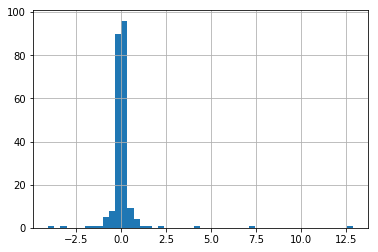

In [613]:
d1.ret[2:].hist(bins=50);

The histogram shows many small positive weekly returns, but the cluster of large negative returns we expect is not seen. We indeed see that there are more days with positive returns than negative returns.

In [620]:
print('Days with positive returns:', d1[d1.ret>0].shape[0])
print('Days with negative returns:', d1[d1.ret<0].shape[0])

Days with positive returns: 120
Days with negative returns: 104


In [627]:
print('Skew of returns:', round(d1.ret[2:].skew(),4))

Skew of returns: 7.4443


Again, the skew is postive which is unexpected for a carry strategy. It's possible that one day of very large positive returns could affect the skew strongly.  

Finally, we show resutls for the Romanian Leu vs. US dollar.

### Romanian Leu vs. US dollar

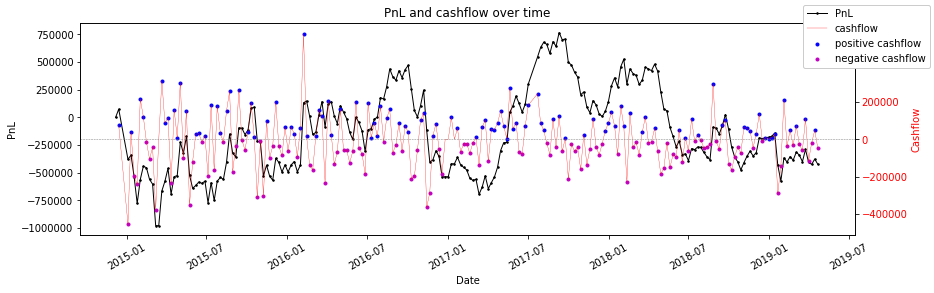

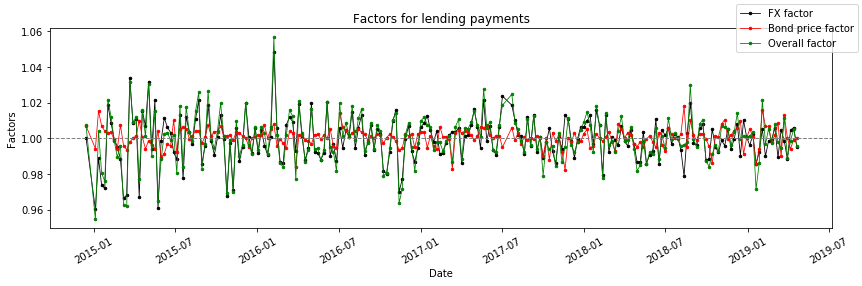

In [629]:
d2 = carry_strategy(data, country1='ROU', country2='USA')
plot_pnl(data=d2,show_cashflow=True,show_factors=True,start=0,end=250)

Final returns: -0.021
Days with positive returns: 101
Days with negative returns: 119
Skew of returns: 11.8391


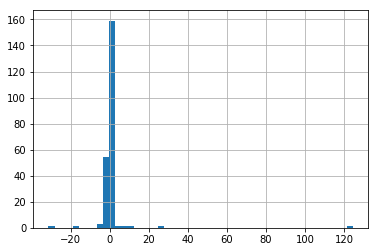

In [628]:
print('Final returns:', round(d2.pnl[-1]/2e7, 3))
d2.ret[2:].hist(bins=50);
print('Days with positive returns:', d2[d2.ret>0].shape[0])
print('Days with negative returns:', d2[d2.ret<0].shape[0])
print('Skew of returns:', round(d2.ret[2:].skew(),4))

The results are, once again, unexpected for a carry strategy.